# Lab 4: Satellite Image Time Series Analysis with GEE and Python
Objective: Extract, process, and analyze satellite image time series data from Google Earth Engine (GEE) using the Python API, with a focus on understanding temporal patterns like trend and seasonality.

## Import libraries and GEE authentication

In [1]:
# Install required libraries (if running in a fresh environment)
# !pip install earthengine-api pandas matplotlib

import ee
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

print("Required libraries imported.")

Required libraries imported.


In [2]:
# Initialize Earth Engine - Colab requires authentication
try:
    ee.Initialize()
    print("Earth Engine initialized successfully.")
except Exception as e:
    print(f"Earth Engine initialization failed. Running 'ee.Authenticate()'...")
    # NOTE: In a fresh Colab environment, you'll need to run ee.Authenticate()
    # and follow the link to get a token.
    ee.Authenticate()
    ee.Initialize(project='kth-digital-image-processing')
    print("Earth Engine authenticated and initialized.")

Earth Engine initialization failed. Running 'ee.Authenticate()'...



Successfully saved authorization token.
Earth Engine authenticated and initialized.


## NDVI Time-Series Modelling Step 1

This part focuses on extracting, processing, and analyzing satellite image time series data to understand temporal patterns in NDVI. Key steps include:

*   Defining the Region of Interest (ROI) and Date Range: Setting the geographical area and time period for the analysis.
*   Loading and Pre-processing Landsat Data: Retrieving Landsat 8 Collection 2 data, masking clouds to ensure data quality, and calculating the Normalized Difference Vegetation Index (NDVI).
*   Adding Time and Constant Bands: Preparing the data for regression by adding a 'fractional_year' band (representing time) and a 'constant' band (for the intercept).
*   Applying Linear Regression: Using Earth Engine's linear regression reducer to model the NDVI trend over the specified time period, estimating parameters like the overall slope and intercept for each pixel. This initial model helps identify long-term changes in vegetation.

In [5]:
# --- 1. DEFINE ROI AND DATES ---
# Define a time range (e.g., 5 years)
START_DATE = '2015-01-01'
END_DATE = '2020-01-01'

# Define a Region of Interest (e.g., a point near a known area of change)
# Using a polygon for a larger visualization area (ROI over farmland near Sacramento, CA)

# area near Zurich
ROI = ee.Geometry.Rectangle([
    8.45, 47.35, 
    8.75, 47.55  
])

# --- 2. LOAD AND PRE-PROCESS LANDSAT DATA (NDVI) ---

# Function to mask clouds for Landsat 8 Collection 2 (L2) data
# C2 uses the 'QA_PIXEL' band for masking.
def mask_clouds_l8_c2(image):
    qa = image.select('QA_PIXEL')
    # Bits 3 (cloud shadow) and 5 (cloud) are typically masked.
    # We also mask 1 (Dilated Cloud), and 4 (Snow/Ice) is often included.
    cloud_mask = (
        qa.bitwiseAnd(1 << 1).eq(0)  # Clear/Dilated Cloud Mask
        .And(qa.bitwiseAnd(1 << 3).eq(0))  # Cloud Shadow Mask
        .And(qa.bitwiseAnd(1 << 5).eq(0))  # Cloud Mask
    )
    return image.updateMask(cloud_mask)

# Function to calculate NDVI and add it as a new band (B5=NIR, B4=Red)
def add_ndvi(image):
    # C2 band names are B4 and B5 (Surface Reflectance)
    ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
    return image.addBands(ndvi)

# Load Landsat 8 Surface Reflectance (Collection 2 Tier 1)
landsat_collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filterDate(START_DATE, END_DATE) \
    .filterBounds(ROI) \
    .map(mask_clouds_l8_c2).map(add_ndvi)

print(f"Landsat Collection size after filtering and masking: {landsat_collection.size().getInfo()} images.")

# --- 3. ADD TIME BAND (FRACTIONAL YEARS) ---

# Function to add a fractional time band to the image.
# This converts the system time (milliseconds) to years since 1970.
def add_time_band(image):
    # Time in fractional years since 1970
    time_since_epoch = image.date().millis().divide(1000 * 60 * 60 * 24 * 365.25)

    # FIX: Convert the ee.Number object to an ee.Image.constant() before renaming.
    # 1. Create a constant image from the time_since_epoch number.
    # 2. Rename the resulting single-band image to 'fractional_year' to avoid conflict with default 'time' column.
    time_image = ee.Image.constant(time_since_epoch).rename('fractional_year').toFloat()

    # The 'constant' band is already a constant image, so it only needs renaming.
    constant_image = ee.Image.constant(1).rename('constant').toFloat()

    # Add 'fractional_year' (predictor) and 'constant' (for intercept) bands
    image = image.addBands(time_image)
    image = image.addBands(constant_image)

    return image

# Map the time function over the pre-processed collection
time_series_collection = landsat_collection.map(add_time_band)

# --- 4. APPLY LINEAR REGRESSION (SERVER-SIDE MODELING) ---

# Define the dependent variable (what we are modeling) and independent variables (predictors)
dependent = 'NDVI'
# Update independents to use 'fractional_year' instead of 'time' to match the new band name.
independents = ['constant', 'fractional_year'] # constant for intercept, fractional_year for slope

# 1. Select only the required bands for the regression
regression_bands = time_series_collection.select(independents + [dependent])

# 2. Define the Linear Regression Reducer (better suited for multiple independent variables)
# This reducer explicitly separates independents and dependent variables.
linear_regression_reducer = ee.Reducer.linearRegression(numX=len(independents))

# 3. Apply the Reducer over the entire ImageCollection.
linear_fit_results = regression_bands.reduce(linear_regression_reducer)

Landsat Collection size after filtering and masking: 174 images.


**Q1** - In the Report explain (i) what are the dependent and independent parameters used in the linear regression. (ii) the role of the function *add_time_bands*.

In [9]:
slope_image = linear_fit_results.select('coefficients') \
    .arrayGet(1) \
    .rename('NDVI_Slope')

Map = geemap.Map(center=[47.45, 8.6], zoom=10)
Map.setOptions('SATELLITE')
Map.addLayer(linear_fit_results.select('coefficients'))
Map

Map(center=[47.45, 8.6], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright', …

**Q2** "You have plotted the results from the linear regression model. What do the white and black features in the map represent? Are they related to a temporal variation of land cover? Justify your answer."

You can also visualize a couple of landsat time-series images from the selected collection to get the clear interpretation.

**Q3** - The linear regression model calculates a single slope over the entire time period for each pixel. Discuss why this might be a suitable or unsuitable approach for capturing all types of temporal changes in NDVI. What other temporal patterns (e.g., seasonality, sudden shifts) might be missed by a simple linear model?

**Experiment 1:** You can use the interactive map above to draw a small polygon over one of the field and you can run the code below to plot the NDVI values. Check at leat 3 different areas on the map and add the plot to your lab report.

**Q4** What is the unknown red line in the plot? Explain how is it computed?

No feature drawn on the map. Using default sample point.
Requesting NDVI data for sample point from GEE servers...
NDVI data received.


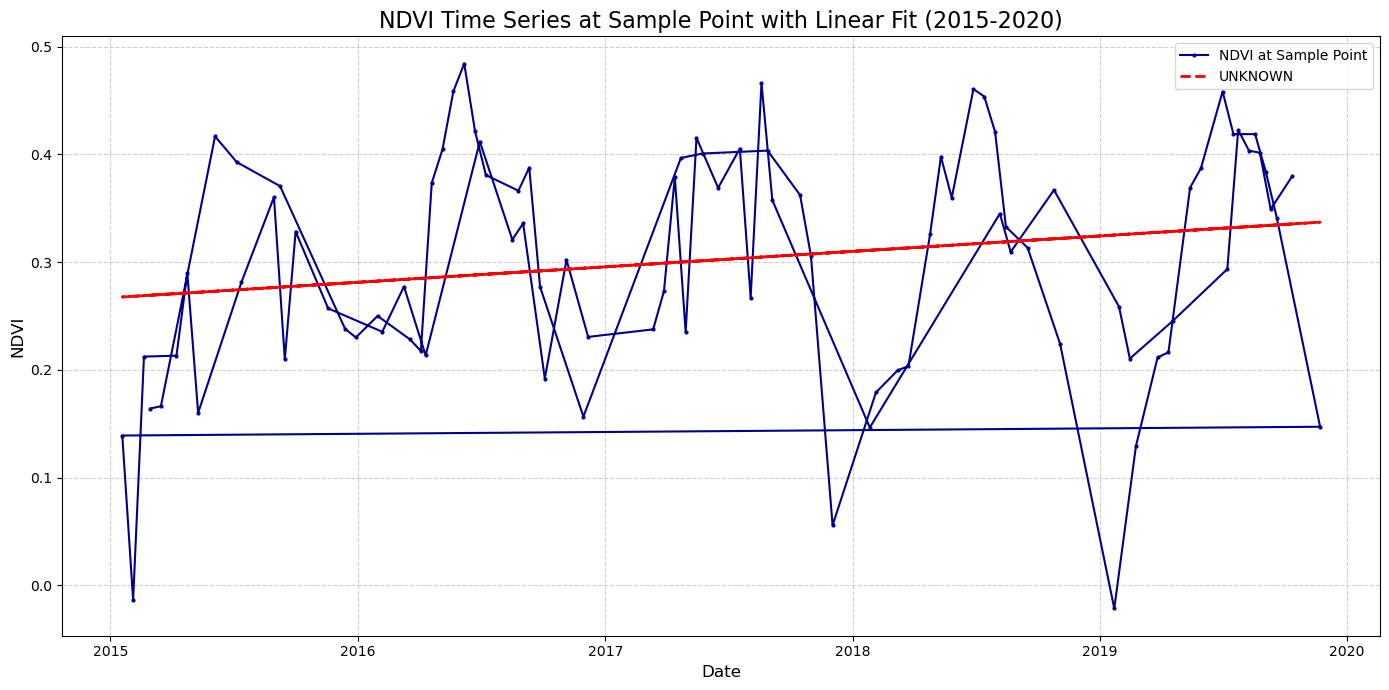

In [13]:
# Function to convert GEE region output (list of lists) to a Pandas DataFrame
def ee_array_to_df(arr, list_of_bands):
    """
    Converts a list of lists from ee.ImageCollection.getRegion to a pandas DataFrame.
    It cleans up the output and sets the 'datetime' as the index.
    """
    # The first row contains the column names
    df = pd.DataFrame(arr[1:], columns=arr[0])

    # Select desired columns and remove intermediate GEE data
    df = df[['id', 'time', *list_of_bands]]

    # Convert 'time' (milliseconds since epoch) to a proper datetime index
    # FIX: Localize to UTC to make it timezone-aware
    df['datetime'] = pd.to_datetime(df['time'], unit='ms').dt.tz_localize('UTC')
    df = df.set_index('datetime').drop(columns=['time', 'id'])

    # Drop rows where the band value is missing (None)
    df = df.dropna()
    return df

# --- Use the last drawn feature from the map ----
if Map.draw_last_feature is not None:
    sample_point = Map.draw_last_feature.geometry()
    print("Using the last drawn feature as sample point.")
    print(sample_point.getInfo())
else:
    # Fallback to a default point if no feature is drawn
    sample_point = ee.Geometry.Point([8.6,47.45])
    print("No feature drawn on the map. Using default sample point.")

# Select only the NDVI band and filter for the sample point
ndvi_collection_for_point = landsat_collection.select('NDVI').filterBounds(sample_point)

# Get the time series of NDVI values for the sample point
print("Requesting NDVI data for sample point from GEE servers...")
ndvi_values_for_point = ndvi_collection_for_point.getRegion(sample_point, 30).getInfo() # Using 30m scale for Landsat
print("NDVI data received.")

# Convert GEE output to DataFrame
ndvi_df = ee_array_to_df(ndvi_values_for_point, ['NDVI'])

# --- Add fitted line from linear_fit_results ---
# Get the coefficients (slope and intercept) for the sample point
coefficients_at_point = linear_fit_results.reduceRegion(
    reducer=ee.Reducer.first(),
    geometry=sample_point,
    scale=30
).getInfo()

intercept = coefficients_at_point['coefficients'][0]
slope = coefficients_at_point['coefficients'][1]

epoch_start = pd.Timestamp('1970-01-01', tz='UTC')
ndvi_df['fractional_year'] = (ndvi_df.index - epoch_start).total_seconds() / (60 * 60 * 24 * 365.25)

ndvi_df['UNKNOWN'] = intercept + slope * ndvi_df['fractional_year']

# Plotting the NDVI time series with the fitted line
plt.figure(figsize=(14, 7))
plt.plot(ndvi_df.index, ndvi_df['NDVI'],
         label='NDVI at Sample Point', marker='.', linestyle='-', markersize=4, color='darkblue')
plt.plot(ndvi_df.index, ndvi_df['UNKNOWN'],
         label='UNKNOWN', linestyle='--', color='red', linewidth=2)

plt.title('NDVI Time Series at Sample Point with Linear Fit (2015-2020)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('NDVI', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## NDVI Time Series Modelling - Part II

Consider the harmonic  model, where
$e_t$ is random error,
$A$ is amplitude,
$ω$ is frequency, and
ϕ is phase:

$$ p_t = β_0 + β_1t + Acos(2πωt - ϕ) + e_t$$

We can decompose our function into separate cosine and sine elements.

$$ p_t = β_0 + β_1t + β_2cos(2πωt) + β_3sin(2πωt) + e_t$$

Note that
$β_2 = Acos(ϕ)$ and $β_3 = Acos(ϕ)$
, implying

$A = (β_2^2+β_3^2)$
 and
$ϕ = atan(β_3/β_2)$.

In simpler terms, we are breaking up more complex curves into a set of simplified cosine waves with an additive term. Mark Jakubauskas has an informative paper that breaks down the process (https://www.isprs.org/proceedings/xxxiii/congress/part4/384_xxxiii-part4.pdf), and there are many resources that elaborate more on the math behind harmonic models.

Building a harmonic model is used in remote sensing applications because of its flexibility in accounting for cyclicality with simple, reproducible shapes. If there is a seasonal trend in the data, the ordered nature of a cosine curve can likely approximate it.

To fit this model to the time series, set
=1 (one cycle per unit time) and use ordinary least squares regression as the metric of error reduction.

In [14]:
# Assuming 'filteredLandsat' is your pre-processed ImageCollection with the 't' band.

# --- 1. Define Independent Variables ---

# Use these independent variables in the harmonic regression.
# 'constant' and 't' (time trend) are already added in a previous step.
# 'cos' and 'sin' are the new harmonic components.
# FIX: Changed 't' to 'fractional_year' to match the actual band name created by add_time_band.
harmonic_independents = ee.List(['constant', 'fractional_year', 'cos', 'sin'])

# --- 2. Define Harmonic Term Function ---

def add_harmonic_terms(image):
    """
    Calculates and adds sine ('sin') and cosine ('cos') bands
    to an image based on the fractional time band ('t').
    """
    # Get the time band ('t') and multiply by 2 * pi for radians (assuming a period of 1 year).
    # FIX: Convert the integer 2 to an ee.Number before multiplication.
    time_radians = image.select('fractional_year').multiply(ee.Number(2).multiply(ee.Number(np.pi)))

    # Calculate and add the cosine and sine bands
    image = image.addBands(time_radians.cos().rename('cos'))
    image = image.addBands(time_radians.sin().rename('sin'))

    return image

# --- 3. Apply the Function to the ImageCollection ---

# Map the function over the Landsat collection to add the harmonic bands.
# Assuming your time-banded collection is named 'time_series_collection' from previous steps.
# If not, use 'filteredLandsat' or whatever name you used.
harmonic_landsat = time_series_collection.map(add_harmonic_terms)

print("Harmonic 'cos' and 'sin' bands added to the image collection.")

Harmonic 'cos' and 'sin' bands added to the image collection.


In [16]:
dependent = 'NDVI'

# Select all independent bands and the dependent band (NDVI).

all_bands = harmonic_independents.add(dependent)

# Note: If harmonic_independents was a Python list, you'd use a Python list:
# all_bands = harmonic_independents.getInfo() + [dependent]

# Filter the collection to only include the bands needed for the reducer.
regression_bands = harmonic_landsat.select(all_bands)


# --- 2. Apply Harmonic Linear Regression ---

# Define the Linear Regression Reducer.
# numX is the number of independent variables (predictors).
# numY is the number of dependent variables (targets), which is 1 (NDVI).
# FIX: Pass numX and numY as direct arguments, not in a dictionary.
harmonic_trend_reducer = ee.Reducer.linearRegression(
    numX=harmonic_independents.size().getInfo(), # Use .size().getInfo() for Python integer length
    numY=1
)

# Apply the Reducer over the entire ImageCollection.
# The output is an array image of coefficients (5x1 matrix: constant, t, cos, sin, bias).
harmonic_trend = regression_bands.reduce(harmonic_trend_reducer)

print("Harmonic regression coefficients calculated successfully.")
# print(harmonic_trend.getInfo()) # Optional: Print metadata

# You can now extract the coefficients (e.g., the slope 't' or the magnitude of 'cos'/'sin')
# For example, to get the Trend (t) coefficient, which is at index 1:
trend_slope_image = harmonic_trend.select('coefficients') \
    .arrayGet(1) \
    .rename('Harmonic_Trend_Slope')

Harmonic regression coefficients calculated successfully.


**Q5** Assume you have a time series with dimensions M x N x T, where M and N represent the number of pixels in the East and North directions, respectively, and T is the number of time steps. How many parameters are estimated in total when using the harmonic model?

In [17]:

# --- 1. Compute Phase and Amplitude ---

# Select the 'coefficients' array band.
coefficients_array = harmonic_trend.select('coefficients')

# Flatten the coefficients array into a multi-band image, where each band is a coefficient.
# This makes 'constant', 'fractional_year', 'cos', 'sin' available as individual bands.
# harmonic_independents = ee.List(['constant', 'fractional_year', 'cos', 'sin'])
harmonic_trend_coefficients_flattened = coefficients_array \
    .arrayProject([0]) \
    .arrayFlatten([harmonic_independents])

# Extract individual coefficients by selecting the named bands.
cos_coeff = harmonic_trend_coefficients_flattened.select('cos')
sin_coeff = harmonic_trend_coefficients_flattened.select('sin')

# Calculate Phase: atan2(sin_coeff, cos_coeff)
# atan2 gives phase in radians [-pi, pi].
phase = sin_coeff.atan2(cos_coeff).rename('Phase')

# Scale Phase to [0, 1] for use as Hue (H).
# Math.PI is replaced by ee.Number(np.pi) (assuming numpy is imported).
# Note: For clarity, we define pi outside the chain.
pi = ee.Number(np.pi)

phase_scaled = phase.unitScale(pi.multiply(-1), pi) \
    .rename('Hue')

# Calculate Amplitude: hypot(sin_coeff, cos_coeff) = sqrt(sin^2 + cos^2)
amplitude = sin_coeff.hypot(cos_coeff).rename('Amplitude')

# Scale Amplitude for visualization (e.g., multiply by 5 for saturation).
amplitude_scaled = amplitude.multiply(5).rename('Saturation')

# --- 2. Compute Mean NDVI (Value Component) ---

# Compute the mean NDVI across the entire time series collection.
mean_ndvi = time_series_collection.select('NDVI').mean().rename('Value')

print("Phase, Amplitude, and Mean NDVI computed.")

# --- 3. HSV to RGB Transformation and Map Visualization ---

# Stack the three component images (Hue, Saturation, Value)
# Hue = Phase (timing of peak/trough)
# Saturation = Amplitude (strength of seasonality)
# Value = Mean NDVI (overall brightness/magnitude)
hsv_image = ee.Image.cat([phase_scaled, amplitude_scaled, mean_ndvi])

# Convert the combined HSV image to an RGB image for display
rgb_image = hsv_image.hsvToRgb()

# Add the resulting RGB image to the map
Map.addLayer(rgb_image, {}, 'Phase (Hue), Amplitude (Sat), Mean NDVI (Val)')
print("Harmonic RGB visualization added to the map.")

# Display the map if you are using geemap/Colab
Map

Phase, Amplitude, and Mean NDVI computed.
Harmonic RGB visualization added to the map.


Map(bottom=367048.0, center=[47.481016589036074, 8.587017059326174], controls=(WidgetControl(options=['positio…

**Experiment 2:** As before, you can use the interactive map above to select some points, and the code below will plot the corresponding NDVI values and fitted model. Try to inspect at least 5 different types of land cover (e.g., crops, urban, forest, water) and add the plots to your lab report. For each case, judge whether the Harmonic model is a reasonable assumption or not; if not, suggest a possible alternative.

Using the last drawn feature as sample point.
{'type': 'Point', 'coordinates': [8.46179, 47.389692]}
Harmonic coefficients flattened into a multi-band image.
Fitted values computed for all images in the collection.
Extracting fitted and original data for plotting...


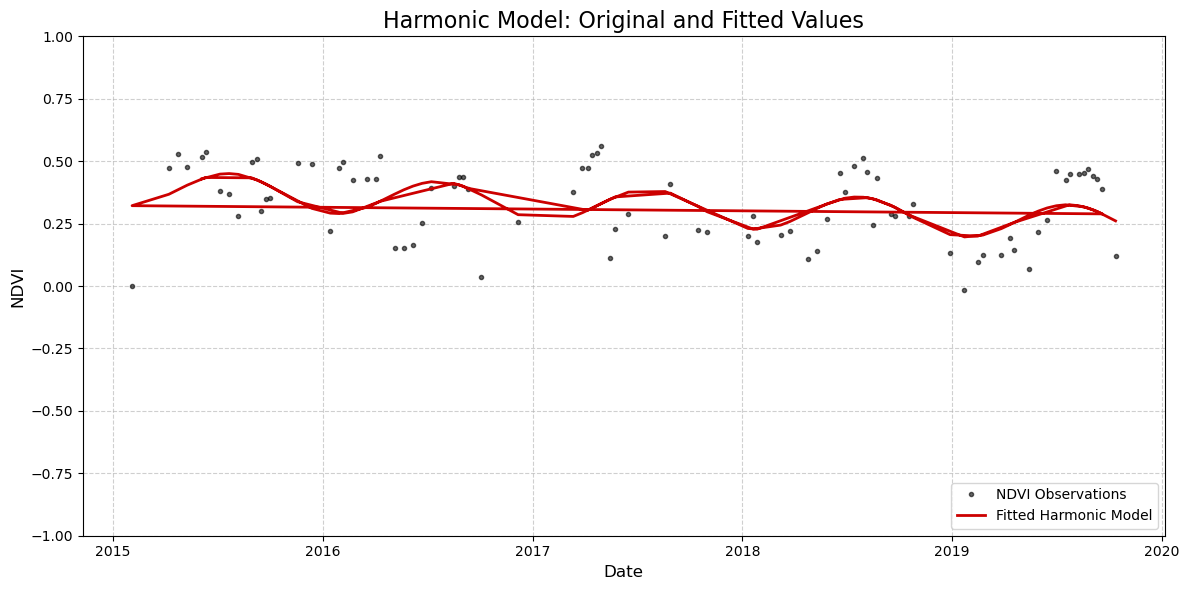


--- Final Data Sample (NDVI vs. Fitted) ---
                                       NDVI    fitted
datetime                                            
2019-07-24 10:16:30.337000+00:00  0.447584  0.325404
2019-08-09 10:16:36.737000+00:00  0.449253  0.321468
2019-08-25 10:16:41.169000+00:00  0.467376  0.312289
2019-09-10 10:16:45.127000+00:00  0.427358  0.298454
2019-10-12 10:16:53.706000+00:00  0.121953  0.260852


In [25]:
# --- Use the last drawn feature from the map ----
if Map.draw_last_feature is not None:
    sample_point = Map.draw_last_feature.geometry()
    print("Using the last drawn feature as sample point.")
    print(sample_point.getInfo())
else:
    # Fallback to a default point if no feature is drawn
    sample_point = ee.Geometry.Point([8.6,47.45])
    print("No feature drawn on the map. Using default sample point.")


# --- 1. Flatten the Array Image to a Multi-Band Image of Coefficients ---

# Select the 'coefficients' band (a 2D array image).
coefficients_array = harmonic_trend.select('coefficients')

# arrayProject([0]) projects the array onto the first axis (rows).
# arrayFlatten flattens the result into a multi-band image, using the
# harmonic_independents list for the new band names.
# NOTE: arrayFlatten expects a list of lists/tuples, so we wrap the ee.List in a Python list.
harmonic_trend_coefficients = coefficients_array \
    .arrayProject([0]) \
    .arrayFlatten([harmonic_independents])

print("Harmonic coefficients flattened into a multi-band image.")

# --- 2. Compute Fitted Values (Server-Side) ---

def compute_fitted_harmonic(image):
    """
    Computes the fitted NDVI value for an image using the pre-calculated coefficients.
    Fitted = (Coefficients) * (Independent Variables) summed up.
    """
    # 1. Select the independent variables ('constant', 't', 'cos', 'sin') from the image.
    predictors = image.select(harmonic_independents)

    # 2. Multiply the predictors by the corresponding coefficient image (matrix multiplication).
    # Since the coefficients are a single image (constant across the map), this works element-wise.
    multiplied_bands = predictors.multiply(harmonic_trend_coefficients)

    # 3. Sum the resulting bands to get the final fitted value (one value per pixel).
    fitted_value = multiplied_bands.reduce('sum').rename('fitted')

    # 4. Add the fitted band back to the original image.
    return image.addBands(fitted_value)

# Apply the fitting function to the harmonic collection.
fitted_harmonic = harmonic_landsat.map(compute_fitted_harmonic)

print("Fitted values computed for all images in the collection.")

# --- 3. Extract and Plot Fitted vs. Original Data (Client-Side) ---

# Extract time series for the original NDVI and the new 'fitted' band.
print("Extracting fitted and original data for plotting...")
raw_data = fitted_harmonic.getRegion(sample_point, 30).getInfo() # Use a 30m scale for Landsat

# Convert the raw data list to a Pandas DataFrame
# We select both the original dependent band and the new 'fitted' band.
df = ee_array_to_df(raw_data, [dependent, 'fitted'])
df = df.rename(columns={dependent: 'NDVI'}) # Rename column to 'NDVI' if needed

# Plot the fitted model and the original data at the ROI using Matplotlib.
plt.figure(figsize=(12, 6))

# Plot original NDVI (Scatter plot/line with markers)
plt.plot(df.index, df['NDVI'], marker='o', linestyle='None', markersize=3,
         color='black', alpha=0.6, label='NDVI Observations')

# Plot fitted harmonic values (Line plot, equivalent to trendline)
plt.plot(df.index, df['fitted'], color='#CC0000', linewidth=2, label='Fitted Harmonic Model')

# Set plot options
plt.title('Harmonic Model: Original and Fitted Values', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('NDVI', fontsize=12)
plt.ylim(-1, 1)
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("\n--- Final Data Sample (NDVI vs. Fitted) ---\n", df.tail())

**Q6** How can you evaluate if a model is a good approximation of the temporal phenomena? Can you propose some metric/statistical index that can be used to assess it?

## MODIS Land Surface Temperature Analysis

This section of the notebook focuses on analyzing Land Surface Temperature (LST) time series data from **MODIS (Moderate Resolution Imaging Spectroradiometer)**. The primary goal is to investigate the Urban Heat Island (UHI) effect.

The **Urban Heat Island (UHI)** effect describes a phenomenon where urban areas experience significantly warmer temperatures than their surrounding rural areas. This temperature difference is primarily caused by modifications to land surfaces in urban environments, such as:


*   **Dark surfaces:** Materials like asphalt and concrete absorb more solar radiation than natural landscapes.

*   **Reduced vegetation:** Less tree cover and green spaces mean less evapotranspiration, which has a cooling effect.

*   **Building geometry:** Tall buildings can trap heat and reduce air circulation.

*   **Anthropogenic heat:** Heat generated by human activities like transportation, industry, and air conditioning.

By comparing LST time series from urban and rural points, this section aims to quantify and visualize the UHI intensity over time.

**Q7** Search online for information about the MODIS satellite sensors you are using. Report their spatial and temporal resolution. Additionally, determine the typical time of day when the images are acquired (e.g., morning or afternoon).

In [26]:
# Helper functions t_modis_to_celsius

def t_modis_to_celsius(t_modis):
    """Converts MODIS LST units to degrees Celsius."""
    # Scale factor 0.02 and Kelvin to Celsius offset 273.15
    t_celsius = 0.02 * t_modis - 273.15
    return t_celsius

In [27]:
O

Requesting data from GEE servers...
Data received.

--- Processed Data Sample (Urban & Rural LST in °C) ---
                            Urban_LST_C  Rural_LST_C
datetime                                           
2017-01-01 00:00:00+00:00         1.55        -2.55
2017-01-09 00:00:00+00:00         2.33         3.23
2017-01-17 00:00:00+00:00         0.35        -0.21
2017-01-25 00:00:00+00:00         9.29        11.07
2017-02-10 00:00:00+00:00        10.65        11.37


In [28]:
# --- 1. SETUP MAP ---
# Create an interactive map centered on the study area (Lyon, France)
Map = geemap.Map(center=[45.7, 4.9], zoom=10)
Map.setOptions('HYBRID') # Use a hybrid satellite/street map background

# --- 2. ADD GEOMETRIES ---
# Define the visual parameters for the points
urban_vis = {'color': 'red', 'pointSize': 8}
rural_vis = {'color': 'green', 'pointSize': 8}

# Add the Urban Point (u_poi)
Map.addLayer(u_poi, urban_vis, 'Urban Point')

# Add the Rural Point (r_poi)
Map.addLayer(r_poi, rural_vis, 'Rural Point')

# --- 3. DISPLAY LEGEND (Optional) ---
Map.add_legend(
    title="Study Points",
    legend_keys=['Urban', 'Rural'],
    legend_colors=['red', 'green']
)

# Display the map
print("Displaying interactive map. You may need to pan/zoom slightly.")
Map

Displaying interactive map. You may need to pan/zoom slightly.


Map(center=[45.7, 4.9], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright', t…

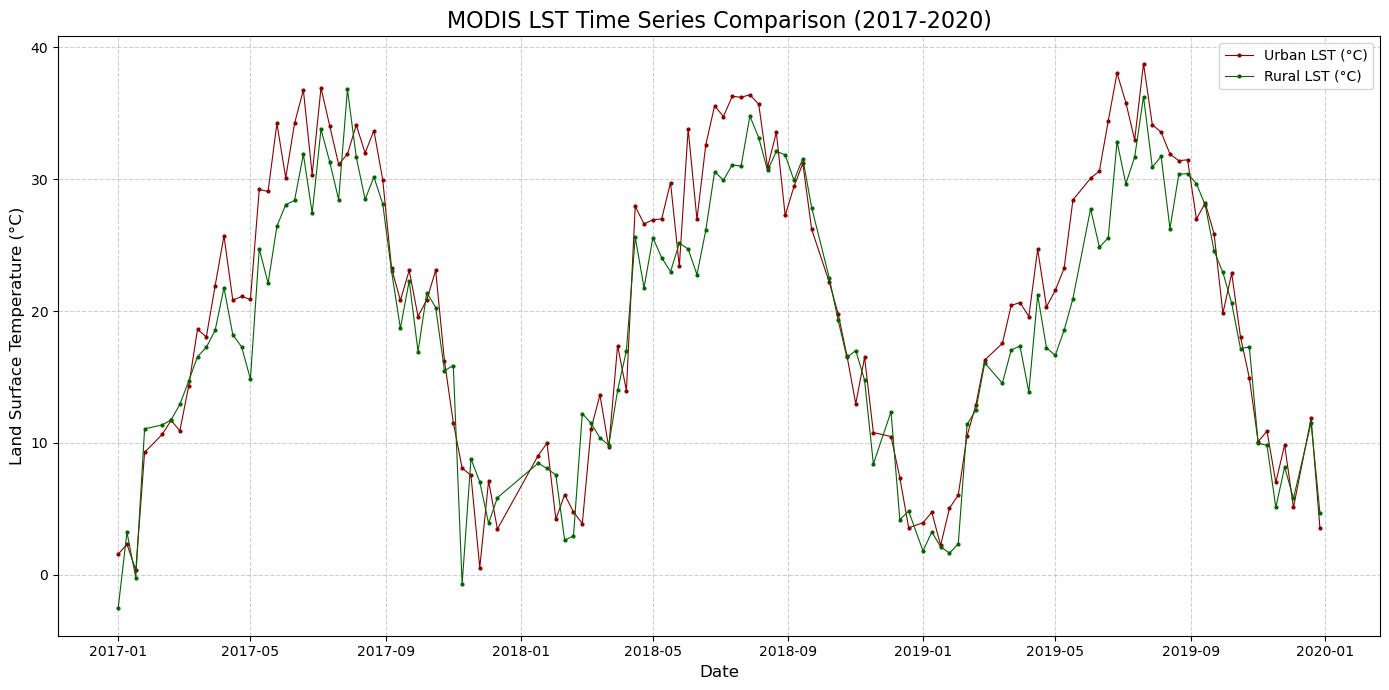

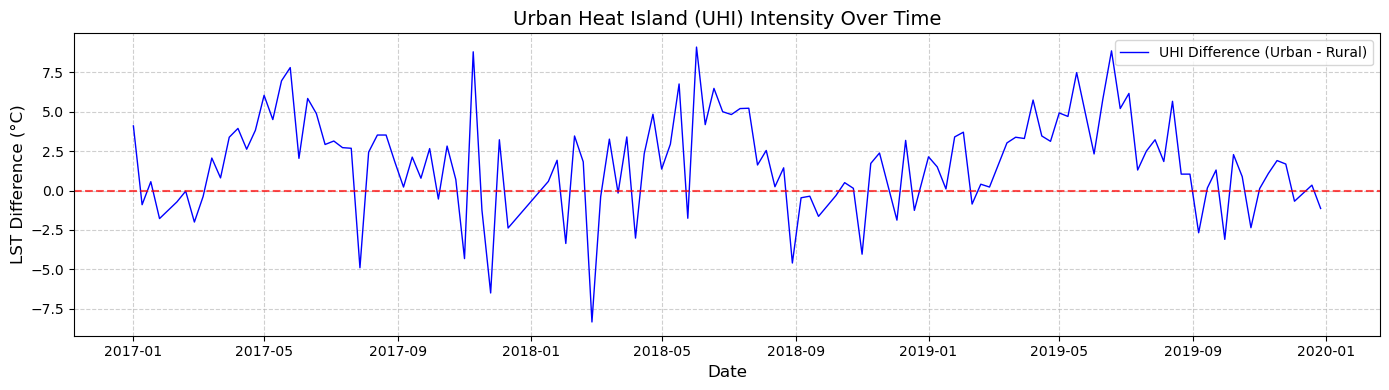

In [29]:
# --- 6. VISUALIZATION ---
# Plotting the time series using Matplotlib
plt.figure(figsize=(14, 7))
plt.plot(combined_df.index, combined_df['Urban_LST_C'],
         label='Urban LST (°C)', marker='.', linewidth=0.8, markersize=4, color='darkred')
plt.plot(combined_df.index, combined_df['Rural_LST_C'],
         label='Rural LST (°C)', marker='.', linewidth=0.8, markersize=4, color='darkgreen')

plt.title('MODIS LST Time Series Comparison (2017-2020)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Land Surface Temperature (°C)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Optional: Calculate and plot the difference (UHI effect)
combined_df['LST_Difference'] = combined_df['Urban_LST_C'] - combined_df['Rural_LST_C']
plt.figure(figsize=(14, 4))
plt.plot(combined_df.index, combined_df['LST_Difference'], label='UHI Difference (Urban - Rural)', color='blue', linewidth=1)
plt.axhline(0, color='red', linestyle='--', alpha=0.7)
plt.title('Urban Heat Island (UHI) Intensity Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('LST Difference (°C)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

**Q8** Explain the plot and if you can see the effect of UHI, add the plot to your lab report.

**Q9** Discuss how the time of acquisition of MODIS data could effect the analysis of UHI. Reflect on what the sensors if measuring and how this is related to the air temperature.